In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# 4x4
            nn.ReLU(),
            nn.Flatten(),                                          # 2048
            nn.Linear(2048, 2)                                     # bottleneck
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(2, 2048),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [3]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import os
from PIL import Image

class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32)),  
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        label = int(row[0])
        image = row[1:].astype(np.uint8).reshape(28, 28) 
        image = np.expand_dims(image, axis=2)  
        image = self.transform(image)

        return image, image, label 

In [4]:
train_dataset = FashionMNISTDataset('/kaggle/input/fashionmnist/fashion-mnist_train.csv')

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

train_loss, recon_losses, kl_losses = [], [], []
for epoch in range(epochs):
    total_loss = 0
    total_recon = 0
    total_kl = 0
    for imgs, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        
        
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        

    train_loss.append(total_loss / len(train_loader))
    
    recon_losses.append(total_recon / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'model_fashion_mnist_autoencoder.pth')

Epoch 1: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]


Epoch [1/10], Loss: 0.0371


Epoch 2: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]


Epoch [2/10], Loss: 0.0249


Epoch 3: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]


Epoch [3/10], Loss: 0.0234


Epoch 4: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]


Epoch [4/10], Loss: 0.0226


Epoch 5: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]


Epoch [5/10], Loss: 0.0220


Epoch 6: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]


Epoch [6/10], Loss: 0.0216


Epoch 7: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]


Epoch [7/10], Loss: 0.0212


Epoch 8: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]


Epoch [8/10], Loss: 0.0211


Epoch 9: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]


Epoch [9/10], Loss: 0.0208


Epoch 10: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]

Epoch [10/10], Loss: 0.0206


In [7]:
model = Autoencoder().to(device)
        
model.load_state_dict(torch.load("/kaggle/working/model_fashion_mnist_autoencoder.pth", 
                                 map_location=device, weights_only=True)
                     )
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

test_dataset = FashionMNISTDataset('/kaggle/input/fashionmnist/fashion-mnist_test.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, _, labels in test_loader:
        imgs = imgs.to(device)
        z = model.encoder(imgs)  # output shape: [batch_size, 2]
        
        all_embeddings.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

embeddings = np.vstack(all_embeddings)
labels = np.concatenate(all_labels).squeeze()

np.save("embeddings.npy", embeddings)
np.save("labels.npy",labels)

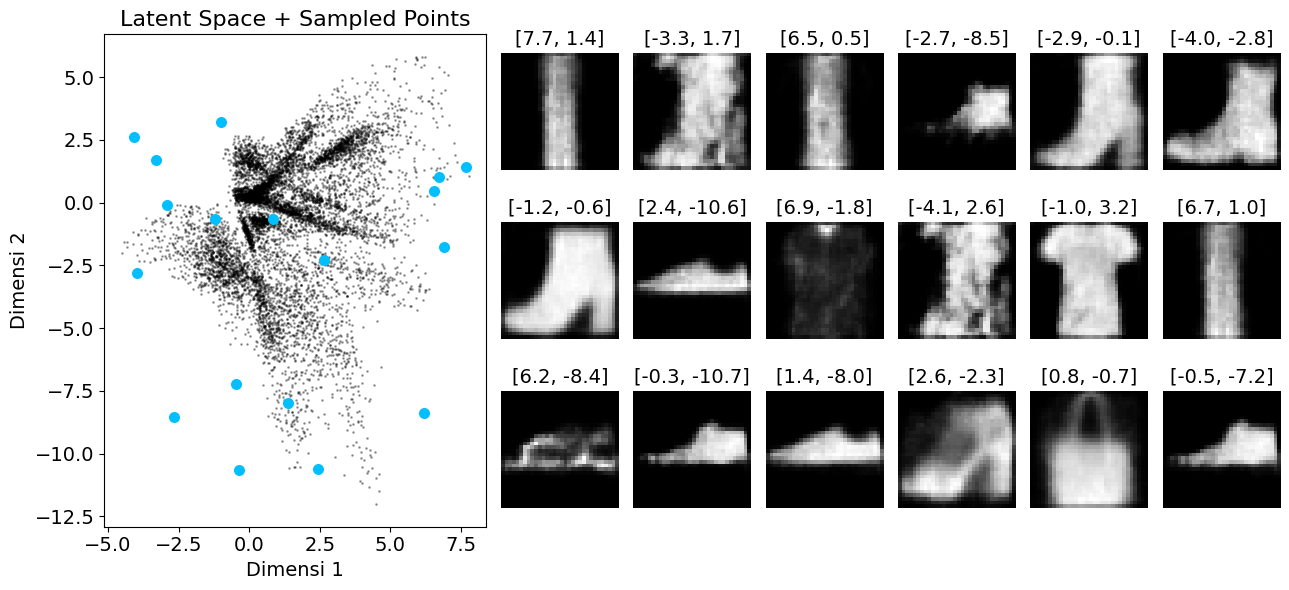

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

embeddings_np = np.load("embeddings.npy")
mins, maxs = np.min(embeddings_np, axis=0), np.max(embeddings_np, axis=0)
samples = np.random.uniform(mins, maxs, size=(18, 2)).astype(np.float32)
samples_tensor = torch.tensor(samples).to(device)

with torch.no_grad():
    reconstructions = model.decoder(samples_tensor).cpu()

fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(3, 9)  # 3 baris, 9 kolom

# Scatter plot di posisi kiri
ax_scatter = fig.add_subplot(gs[:, :3])  # seluruh baris, kolom 0–2
ax_scatter.scatter(embeddings_np[:, 0], embeddings_np[:, 1], c='black', s=1, alpha=0.3)
ax_scatter.scatter(samples[:, 0], samples[:, 1], c='deepskyblue', s=48)
ax_scatter.set_title("Latent Space + Sampled Points", fontsize=16)
ax_scatter.set_xlabel("Dimensi 1", fontsize=14)
ax_scatter.set_ylabel("Dimensi 2", fontsize=14)
ax_scatter.tick_params(axis='both', labelsize=14) 

# Grid 3x6 hasil rekonstruksi di kanan (kolom 3–8)
for i in range(18):
    row, col = divmod(i, 6)
    ax_img = fig.add_subplot(gs[row, 3 + col])
    ax_img.imshow(reconstructions[i].squeeze(), cmap='gray')
    ax_img.set_title(f"[{samples[i][0]:.1f}, {samples[i][1]:.1f}]", fontsize=14)
    ax_img.axis("off")

plt.tight_layout()
plt.show()